In [4]:
# 데이터 출처: https://archive.ics.uci.edu/dataset/222/bank+marketing
# Github 출처: https://github.com/uci-ml-repo/ucimlrepo

#기본 모듈 불러오기 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# # warning을 모두 무시하는 것은 좋지 않으나 과제 수행을 쉽게할 수 있도록 무시설정
# import warnings
# warnings.filterwarnings(action='ignore')

# 전체 계획
1. 데이터 로드 & 분리
    * train / test 데이터 분리
2. 탐색적 데이터 분석(EDA)
    * 분포확인 & 이상치 확인
3. 데이터 전처리
    * 데이터 비율 맞춰주기 위해 Oversampleing
        - 단, SMOTE 알고리즘은 수치형 데이터에만 쓸 수 있으니
        - SMOTE를 범주형 데이터에도 쓸 수 있게 확장한 SMOTENC를 사용
    * 결측치 처리 -> 존재X
        - 수치형: 
        - 범주형: 
        - 삭제 : 
    * 전처리
        - 수치형: 
        - 범주형
            - 레이블 인코딩: 
            - 원- 핫 인코딩: 
    
4. 모델 수립
5. 평가

# 1. 데이터 로드 & 분리

## 문제1: 라이브러리를 통해 데이터 불러오기
- 다음코드는 데이터를 불러오고 df 변수명에 저장하는 코드입니다.
- github 문서를 읽고 데이터를 요청하여 로컬환경에 저장해보세요

In [5]:
# 이거 쓰면 좀 렉걸리는 듯해서 첫 실행제외하고는 굳이 할 필요없어서 주석처리해둠
# # df2 = pd.read_csv('F:/sparta_python/ML/bank+marketing/bank-full.csv', sep=';') # 파일로 다운받아서 불러오는 경우
# # display(df2.head(3))
# from ucimlrepo import fetch_ucirepo, list_available_datasets
# # check which datasets can be imported
# # list_available_datasets()
# # import dataset
# Bank_Marketing = fetch_ucirepo(id=222)
# df = Bank_Marketing.data.original
# # df = pd.DataFrame(data=Bank_Marketing.data.original)
# df.to_csv('./bank_marketing.csv')

# # 확인용
# display(df.head(3)) #단 설명에 있는 컬럼과 올려진 파일 컬럼이 day_of_week로 설명되어있는게 파일에는 day로 되어있음

## 데이터 train과 test로 분리

In [6]:
# 데이터 불러오기 
df = pd.read_csv('./bank_marketing.csv') # 라이브러리를 통해 불러온 데이터를 저장하여 다시 파일로써 불러오는 것
# df2 = pd.read_csv('F:/sparta_python/ML/bank+marketing/bank-full.csv', sep=';') # 다운받은 데이터로 확인하는 법

# 우선 X와 y분리
X = df.drop(columns=['y']) # 제거 된채로 원본 df에 저장되는게 아님
y = df[['y']]

# 학습과 평가 위해서 train과 test로 나눠줌
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, stratify=y)

# 수치형 데이터와 범주형 데이터 분류해서 저장
numeric_col = ['age','balance','day_of_week','duration','campaign','pdays','previous']
category_col = ['job','marital','education','default','housing','loan','contact','month','poutcome']

# 분리한 데이터 크기 확인
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31647, 17) (13564, 17) (31647, 1) (13564, 1)


# 2. EDA

### 결측치 확인
train데이터 기준으로 아래에서 확인해본 결과
- contact: 9100개, poutcome: 25917개
- job: 206개, education: 1314개 
- pdays: NaN값은 없음, -1로 표기된 것보고 결측치라 설명한듯?(이전 캠페인에서 연락하지 않은 경우) 25912개 존재
    
관련하여서 어떻게 처리해줄지는 심화부분에서 고민해보기

In [7]:
X_train.info()
X_train.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 31647 entries, 13382 to 3184
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   31647 non-null  int64 
 1   age          31647 non-null  int64 
 2   job          31441 non-null  object
 3   marital      31647 non-null  object
 4   education    30333 non-null  object
 5   default      31647 non-null  object
 6   balance      31647 non-null  int64 
 7   housing      31647 non-null  object
 8   loan         31647 non-null  object
 9   contact      22547 non-null  object
 10  day_of_week  31647 non-null  int64 
 11  month        31647 non-null  object
 12  duration     31647 non-null  int64 
 13  campaign     31647 non-null  int64 
 14  pdays        31647 non-null  int64 
 15  previous     31647 non-null  int64 
 16  poutcome     5730 non-null   object
dtypes: int64(8), object(9)
memory usage: 4.3+ MB


Unnamed: 0         0
age                0
job              206
marital            0
education       1314
default            0
balance            0
housing            0
loan               0
contact         9100
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       25917
dtype: int64

In [8]:
X_train['poutcome'].value_counts()

poutcome
failure    3378
other      1301
success    1051
Name: count, dtype: int64

In [9]:
X_train['poutcome'].count()

5730

In [10]:
# X_test.info()
# display(X_test.describe(include='all'))
# X_test.isna().sum() # 결측치는 없음

In [11]:
X_train['contact'].value_counts()

contact
cellular     20517
telephone     2030
Name: count, dtype: int64

In [12]:
X_train.shape
X_train.count()

Unnamed: 0     31647
age            31647
job            31441
marital        31647
education      30333
default        31647
balance        31647
housing        31647
loan           31647
contact        22547
day_of_week    31647
month          31647
duration       31647
campaign       31647
pdays          31647
previous       31647
poutcome        5730
dtype: int64

In [13]:
X_train['pdays'].value_counts()

pdays
-1      25912
 182      114
 92        97
 91        89
 181       79
        ...  
 425        1
 805        1
 455        1
 445        1
 382        1
Name: count, Length: 516, dtype: int64

In [14]:
# df['pdays'].value_counts()
X_train['pdays'].count()

31647

In [15]:
X_train['poutcome'].value_counts()

poutcome
failure    3378
other      1301
success    1051
Name: count, dtype: int64

In [16]:
X_train['previous'].nunique()

41

### 기술통계를 통한 EDA

In [17]:
X_train.describe(include = 'all')

,Unnamed: 0,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
count,31647.000000,31647.000000,31441,31647,30333,31647,31647.000000,31647,31647,22547,31647.000000,31647,31647.000000,31647.000000,31647.000000,31647.000000,5730
unique,NaN,NaN,11,3,3,2,NaN,2,2,2,NaN,12,NaN,NaN,NaN,NaN,3
top,NaN,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,failure
freq,NaN,NaN,6866,19049,16201,31083,NaN,17625,26573,20517,NaN,9643,NaN,NaN,NaN,NaN,3378
mean,22602.388062,40.883022,NaN,NaN,NaN,NaN,1363.589535,NaN,NaN,NaN,15.806712,NaN,258.755143,2.760040,39.869498,0.584795,NaN
std,13044.705146,10.621809,NaN,NaN,NaN,NaN,3070.235315,NaN,NaN,NaN,8.331080,NaN,259.880162,3.104999,99.674113,2.490925,NaN
min,0.000000,18.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,-1.000000,0.000000,NaN
25%,11303.500000,33.000000,NaN,NaN,NaN,NaN,74.000000,NaN,NaN,NaN,8.000000,NaN,103.000000,1.000000,-1.000000,0.000000,NaN
50%,22595.000000,39.000000,NaN,NaN,NaN,NaN,451.000000,NaN,NaN,NaN,16.000000,NaN,180.000000,2.000000,-1.000000,0.000000,NaN
75%,33911.500000,48.000000,NaN,NaN,NaN,NaN,1427.500000,NaN,NaN,NaN,21.000000,NaN,318.000000,3.000000,-1.000000,0.000000,NaN


### 시각화를 통한 EDA

#### 수치형 데이터 시각화

In [18]:
X_train['duration'].value_counts() #확인해본 결과 저렇게 이상하게 나오는 건 맞는데 확인할 때 계산해준 값으로 쓰인 것들이 이상함

duration
124     142
89      135
90      133
104     130
139     130
       ... 
2219      1
1294      1
1665      1
1489      1
1191      1
Name: count, Length: 1467, dtype: int64

In [19]:
# print(X_train['campaign'].max(),X_train['campaign'].min())
X_train['campaign'].value_counts().max()

12294

In [20]:
for check_col in ['age', 'day_of_week', 'previous', 'balance', 'duration', 'campaign']:
    print(check_col, " : ", len(set(X_train[check_col])))

age  :  77
day_of_week  :  31
previous  :  41
balance  :  6255
duration  :  1467
campaign  :  47


In [28]:
# 그래프 bin관련 파악 부분
'''
bin갯수 결정 알고리즘 : https://chat.openai.com/share/af07e311-7aa3-45fa-980e-ee69c2eb84c6
Freedman-Diaconis' Choice방식 사용
데이터의 분포를 고려하여 bin의 폭을 결정한 후에 전체 데이터 범위를 그 폭으로 나누어 bin의 갯수를 계산
전체 데이터 범위는 그냥 최대값 - 최솟값으로 구한다고 한다 따라서 .max()-.min()을 해주면 될듯하다
bin의 폭(bin width)은 2*(IQR/N**(1/3))으로 구하고
IQR은 Q3 - Q1으로 Q3와 Q1는 np.percentile(data, 75)와 np.percentile(data, 25)로 구할 수 있다
N은 데이터의 샘플 갯수로 왜인지는 모르겠지만 중복을 포함하여 총 데이터 값의 갯수라고 한다 .count()를 쓰면 될듯하다

'''
for check_col in ['age', 'day_of_week', 'previous', 'balance', 'duration', 'campaign']:
    print(check_col, "의 최대, 최소값 : ", X_train[check_col].max(), X_train[check_col].min())
    
print('\n')

for check_col in ['age', 'day_of_week', 'previous', 'balance', 'duration', 'campaign', 'pdays']:
    entire_range = X_train[check_col].max() - X_train[check_col].min()
    q1 = np.percentile(X_train[check_col], 25)
    q3 = np.percentile(X_train[check_col], 75)
    IQR = q3 - q1
    N = X_train[check_col].count()
    distinct_n = X_train[check_col].nunique()
    mean = X_train[check_col].mean()
    std = X_train[check_col].std()
    cv = X_train[check_col].std() / X_train[check_col].mean() #변동계수라는 값이라고 한다
    skew = X_train[check_col].skew() #왜도
    bin_width = 2 * (IQR / N**(1/3))
    num_bin = entire_range / bin_width
    print(check_col, "의 전체범위는 ", entire_range)
    print(check_col, "의 q1과 q3는 ", q1, q3)
    print(check_col, "의 IQR은 ", IQR)
    print(check_col, "의 N은 ", N)
    print(check_col, "의 distinct_n은 ", distinct_n)
    print(check_col, "의 평균은 ", mean)
    print(check_col, "의 표준편차는 ", std)
    print(check_col, "의 변동계수는 ", cv)
    print(check_col, "의 왜도는 ", skew)
    print(check_col, "의 bin너비는 ", bin_width)
    print(check_col, "의 bin갯수는 ", num_bin,'\n')
    
for check_col in ['age', 'day_of_week', 'previous', 'balance', 'duration', 'campaign', 'pdays']:
    entire_range = X_train[check_col].max() - X_train[check_col].min()
    q1 = np.percentile(X_train[check_col], 25)
    q3 = np.percentile(X_train[check_col], 75)
    IQR = q3 - q1
    N = X_train[check_col].count()
    distinct_n = X_train[check_col].nunique()
    bin_width = 2 * (IQR / N**(1/3))
    num_bin = entire_range / bin_width
    print(check_col, "의 bin갯수는 ", num_bin)

age 의 최대, 최소값 :  95 18
day_of_week 의 최대, 최소값 :  31 1
previous 의 최대, 최소값 :  275 0
balance 의 최대, 최소값 :  102127 -8019
duration 의 최대, 최소값 :  4918 0
campaign 의 최대, 최소값 :  63 1


age 의 전체범위는  77
age 의 q1과 q3는  33.0 48.0
age 의 IQR은  15.0
age 의 N은  31647
age 의 distinct_n은  77
age 의 평균은  40.88302208740165
age 의 표준편차는  10.62180867645002
age 의 변동계수는  0.25980977271548605
age 의 왜도는  0.6971867836177476
age 의 bin너비는  0.948441187696314
age 의 bin갯수는  81.18584578452007 

day_of_week 의 전체범위는  30
day_of_week 의 q1과 q3는  8.0 21.0
day_of_week 의 IQR은  13.0
day_of_week 의 N은  31647
day_of_week 의 distinct_n은  31
day_of_week 의 평균은  15.806711536638543
day_of_week 의 표준편차는  8.33108016690778
day_of_week 의 변동계수는  0.5270596700393425
day_of_week 의 왜도는  0.09386807837918064
day_of_week 의 bin너비는  0.8219823626701388
day_of_week 의 bin갯수는  36.49713346956447 

previous 의 전체범위는  275
previous 의 q1과 q3는  0.0 0.0
previous 의 IQR은  0.0
previous 의 N은  31647
previous 의 distinct_n은  41
previous 의 평균은  0.5847947672765191
previous 의 표준편차

C:\Users\kssg1\AppData\Local\Temp\ipykernel_33284\3704664215.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  num_bin = entire_range / bin_width
C:\Users\kssg1\AppData\Local\Temp\ipykernel_33284\3704664215.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  num_bin = entire_range / bin_width


age 의 bin :  81.18584578452007
balance 의 bin :  1287.037862844537
day_of_week 의 bin :  36.49713346956447
duration 의 bin :  361.7686405028116
campaign 의 bin :  490.278159607816


C:\Users\kssg1\AppData\Local\Temp\ipykernel_33284\1283592472.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  num_bin = entire_range / bin_width


pdays 의 bin :  inf
previous 의 bin :  inf


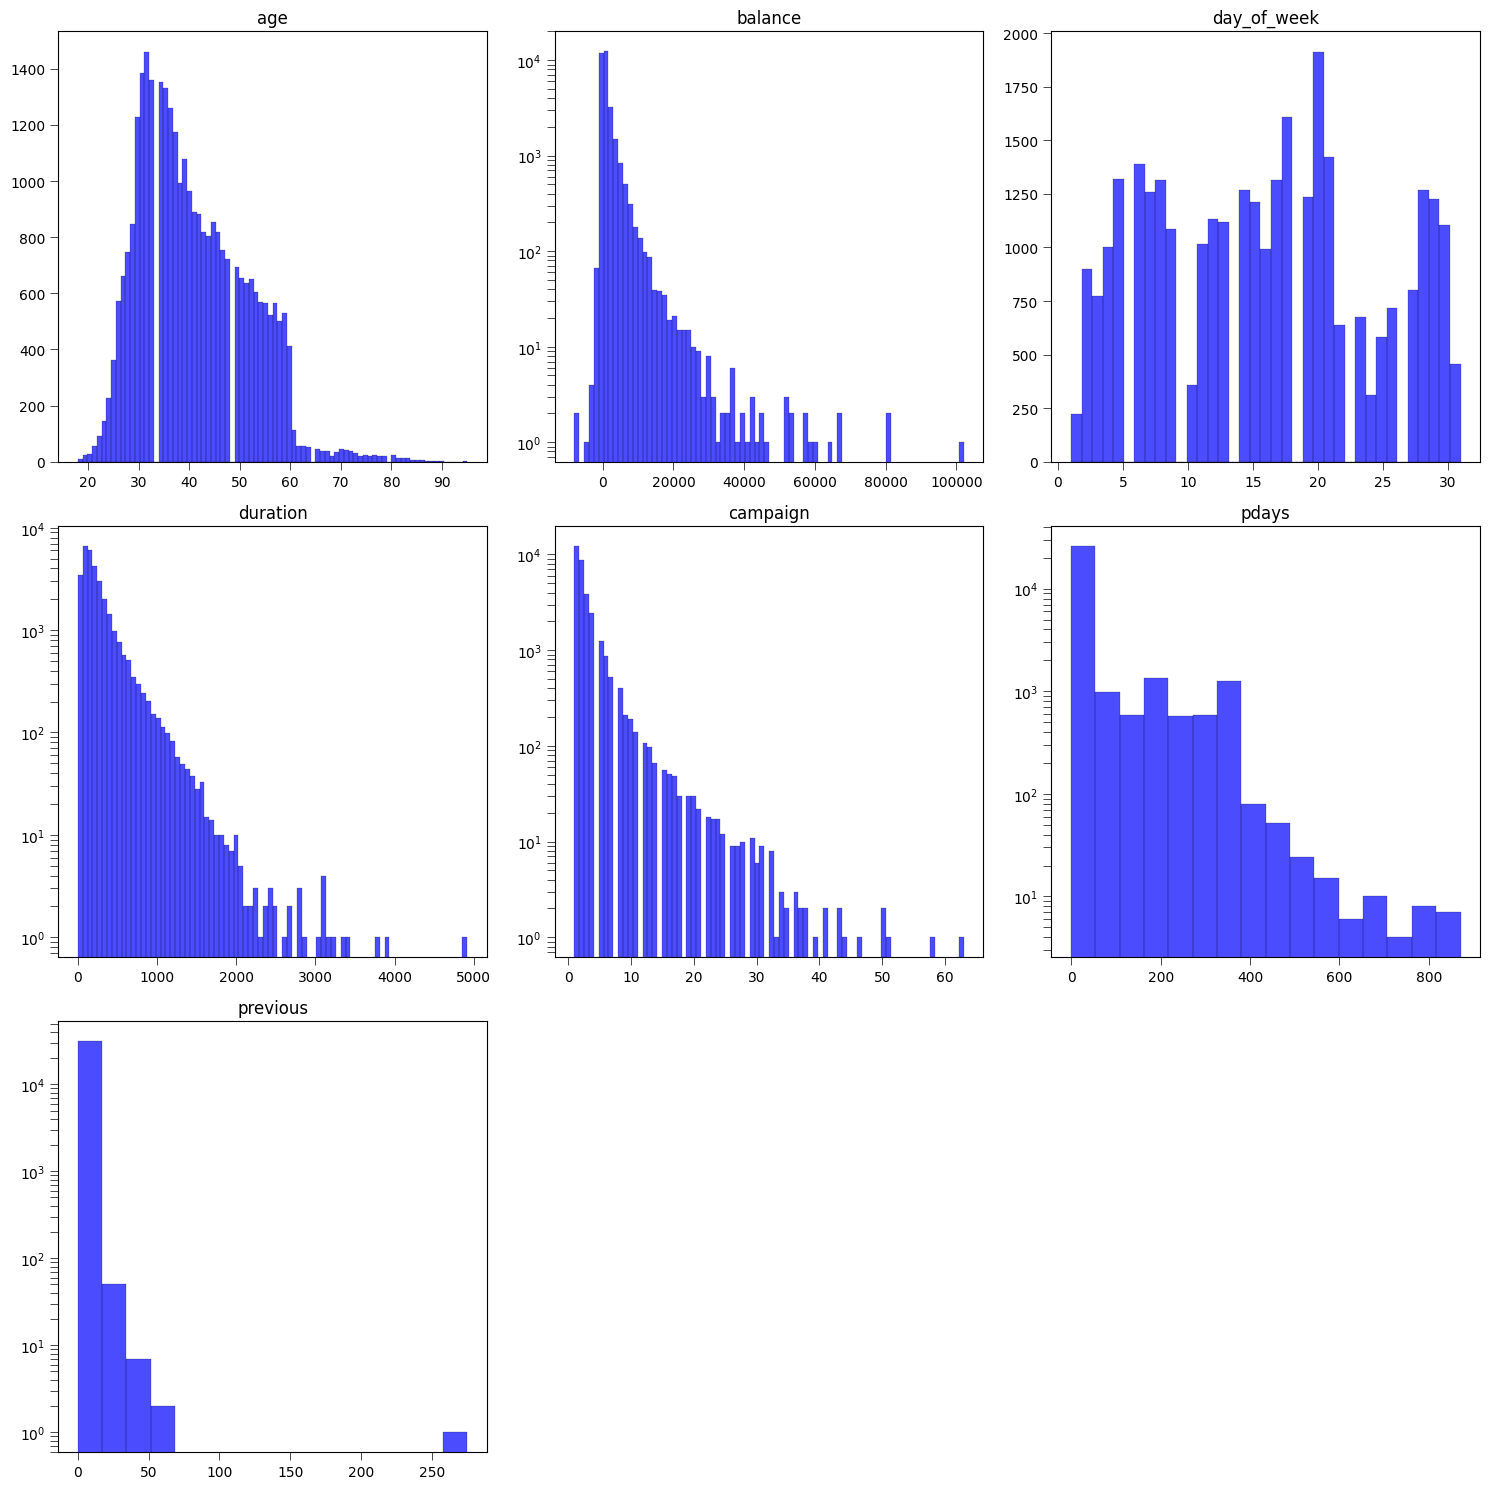

In [34]:
from matplotlib.ticker import MultipleLocator
import math
#수치형 변수 시각화
def get_3_hist(data:pd.DataFrame, columns:list, log_scale_threshold: float = 5000, num_bin_max: int = 300 ):
    """ 데이터와 컬럼을 전달하면 히스토그램을 3개씩 출력해주는 함수

    Args:
        data (pd.DataFrame): 데이터프레임
        columns (list): 컬럼 리스트
        bar_width_ratio(float): 원하는 비율로 설정 (예시로 0.005 사용)
    """
    num_plots = len(columns)
    num_rows = (num_plots + 2) // 3  # 서브플롯의 행 수 계산
    num_cols = min(num_plots, 3)  # 서브플롯의 열 수 계산
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    
    for i, col in enumerate(columns):
        row_idx, col_idx = divmod(i, 3)
        axes[row_idx, col_idx].clear()
        
        # Freedman-Diaconis' Choice방식으로 bin 갯수 얼추 계산해본 뒤 판단
        entire_range = X_train[col].max() - X_train[col].min() # 데이터 값 최대와 최소 차이
        q1 = np.percentile(X_train[col], 25)
        q3 = np.percentile(X_train[col], 75)
        IQR = q3 - q1
        N = X_train[col].count()
        bin_width = 2 * (IQR / N**(1/3))
        num_bin = entire_range / bin_width
        # print(col, "의 bin : ", num_bin) # 점검용
        if (not math.isinf(num_bin)) and num_bin > num_bin_max:
            n_bins = 80
        else:
            n_bins = 'auto'
        
        # # Wand 규칙을 사용하여 동적으로 bin의 개수 설정
        # if bar_width_ratio < bar_width_ratio_min:  # 전체 스케일에 대한 막대 두께의 비율이 너무 작으면
        #     n_bins = int(np.sqrt(len(set(data[col])))*1.0) 
        #     # 조금더 줄이면 깔끔히 잘보이지 않을까해서 0.8곱했다가 별차이없는듯해서 1.0으로 원 위치(원래 곱해진 것 따로 없었음)
        # else:
        #     n_bins = 'auto'
        
        hist, bins, _ = axes[row_idx, col_idx].hist(data[col], bins=n_bins, color='blue', edgecolor='blue', linewidth=0.2, alpha=0.7)
        num_bin_actual = len(bins) - 1  # 실제로 그려진 막대의 갯수
        #sns.histplot(data[col], ax=axes[row_idx, col_idx], bins=n_bins, color='blue', edgecolor='blue', linewidth=0.2, alpha=0.7, kde=False)
        
        axes[row_idx, col_idx].set_title(col)
        axes[row_idx, col_idx].tick_params(axis='both', which='both', direction='out', length=6, width=0.5)  # 눈금 표시
        
        bar_heights = [rect.get_height() for rect in axes[row_idx, col_idx].patches]
        max_height = max(bar_heights)
        min_height = max(min(bar_heights),1)
        
        # print(col, " 높이차는 이러함 : ", max_height / min_height, max_height, min_height) # 점검용
        # print(col, " bin : ", num_bin_actual) # 점검용
        
        # 히스토그램 바의 높이 차이에 따라 리니어 스케일 또는 로그 스케일 선택
        if (max_height / min_height) > log_scale_threshold:
            axes[row_idx, col_idx].set_yscale('log')  # 로그 스케일로 변환
        else:
            axes[row_idx, col_idx].set_yscale('linear')  # 리니어 스케일로 유지
        
        # 전체 그래프 스케일에 대한 막대 자체의 두께 비율 계산
        total_width = axes[row_idx, col_idx].get_xlim()[1] - axes[row_idx, col_idx].get_xlim()[0]
        
        
        
        # 히스토그램 바의 두께가 조건에 따라 테두리 색 설정
        for rect in axes[row_idx, col_idx].patches:
            bar_width = rect.get_width()
            if bar_width / total_width > 0.005: # 그냥 저쯤보다 얇은 경우 테두리 없는게 나은듯해서 설정해줌
                rect.set_edgecolor('black')
            else:
                rect.set_edgecolor('none')  # 얇은 경우에는 테두리 없애기
        
        # # Seaborn axis 객체로부터 눈금 위치 확인
        # tick_locs = sns.histplot(data[col]).axes.get_xticks()
        # print(f"{col}의 현재 x 축 눈금 위치: {tick_locs}")

    # 남은 서브플롯에 빈 그래프 그리기
    for i in range(num_plots, num_rows * num_cols):
        row_idx, col_idx = divmod(i, 3)
        axes[row_idx, col_idx].clear()  # 남은 서브플롯 비우기
        axes[row_idx, col_idx].axis('off')  # 빈 서브플롯 제거
        
    

    # 전체 그림 표시
    plt.tight_layout()
    plt.show()
get_3_hist(X_train, numeric_col)

여기부분 label 두번씩 나오는데 이거 확인하고 수정하기 ->어케 수정한지 자세히는 기억안나는데 어떻게든 일단 수정했고  
그리고 campaign 얘 먼데 그렇게 그래프 보기 힘들게 안나올만한 갯수들과 값차이 들인데 이상하게 나오는게 이상해서 데이터 살펴봐야할듯

수치형 시각화 판단 결과
이상치가 많아서 left skewness 발생한 경우 :log scale

# 3. 데이터 전처리

## 문제2: Y 변수 인코딩 적용하기

# 4. 모델 수립

# 5. 평가